# Computing Assignment 2
## Hashing

In this group-oriented computing assignment, we will explore the development of a probabilistic analysis for chain hashing.  Hashing is another quintessential example for which randomness plays an essential role in its good performance.  Interestingly - and orthogonally to our analysis of quicksort - the expected performance is straightforward to understand, whereas it is more difficult to understand the worst cases.  

This notebook consists of three parts.  
- In the first part, we will analyze four probabilistic questions that are reasonable to ask regarding the complexity of hashing.  For each of these questions, I will first ask you to work together to derive an appropriate (analytical) probabilistic model, and then to use direct simulation (by "hashing" to random indices in the hash table) to empirically verify your theory.
- In the second part, we will explore some hash functions and analyze the degree to which data that is hashed by them is consistent with the probabilistic models that we developed previously.
- In the third part, you will on your own code construct a very interesting hash table-adjacent data structure called a Bloom filter, and emprically analyze its behavior.

## Part 1 - Balls and Bins
### A: Reference implementation
Before delving into theory, it is useful to have a toy model that can help build intuition and from which empirical results can be derived.  To this end, we can - at this stage - abstract away much of the function of a hash table.  In particular, while a chaining hash table typically is constructed by deterministically mapping real data-derived keys (like strings or integers or whatever) to the indices of an array via a hash function, and then appending the key-value pair to a list stored at that position, we can simulate this process in the absence of data - and subject perfectly to the uniform hashing assumption - by uniformly generating random indices, and incrementing a counter (which serves as a stand-in for the length of the list associated with that position in the hash table).  **For table size $n$ and number of items $m$, write a short piece of code that populates our pseudo-hash table as described above.**  *We will principally be interested in the "length" of the lists stored in the hash table - verify that your implementation is functioning correctly by comparing the average length of the list to the expected list length (which you can either hand-wave or derive explicitly*.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def populate_hash_table(n, m):
    table = np.zeros(n)
    for _ in range(m): # populate the hash table
        idx = np.random.randint(0, n) # get the random index
        table[idx] += 1
    return table

n = 100
m = 1000
table = populate_hash_table(n, m)
# compare the average length to the expected list length
print(np.mean(table), m/n)

In [ ]:
table

In [ ]:
plt.hist(table, bins=int(table.max()) - int(table.min()))

### B: Time until collision
The complexity of accessing elements in a chaining hash table is obviously proportional to the length of the list holding the item.  To that end, it is tempting to try to set up our hash tables in such a way so as to make sure that collisions (when different data are hashed to the same location in the hash table) don't occur.  **Derive the probability of observing a collision after adding $m$ items to a hash table of size $n$.** *Note that you may have seen this problem before, perhaps under a different name.  There are two ways to solve it.  The first (more difficult) way is via induction: the probability that there has been a collision after a single element has been added is zero.  The probability that there is a collision after adding another element is the probability that there has already been a collision plus the probability that there hasn't time the probability that the new element induces a collision.  The second way is to work with the complement: the probability that we have a collision with $m$ elements added to the table is one minus the probability that we don't have a collision.*  **Once this derivation is complete, perform multiple trials using the code that you developed in Part A and compare empirical and theoretical results.**

The derived probability that a collision occurs after $m$ items have been added to a hash table of size $n$ is given by the formula:

$$1 - \frac{n!}{n^m(n-m)!}$$

where $n!$ is the factorial of $n$.  This formula can be derived by considering the complement of the event that there is a collision.  The probability that there is no collision after $m$ items have been added is the probability that the first item is added to an empty bin, the second item is added to an empty bin, and so on.  This probability is given by the formula $\frac{n}{n} \cdot \frac{n-1}{n} \cdot \ldots \cdot \frac{n-m+1}{n} = \frac{n!}{n^m(n-m)!}$.  

In [ ]:
# empirical example of collision chance after m items have been inserted into a hash table of size n
def collision_chance(n, m):
    table = populate_hash_table(n, m)
    return np.sum(table > 1) / n # sum the number of collisions (i.e. elements > 1) and divide by n

def collision_chance_theoretical(n, m):
    ...

n = 100
m = 1000
# plot collision chance as a function of m
plt.plot([collision_chance(n, m) for m in range(1, 1000)])
plt.xlabel('m')
plt.ylabel('collision chance')
plt.show()

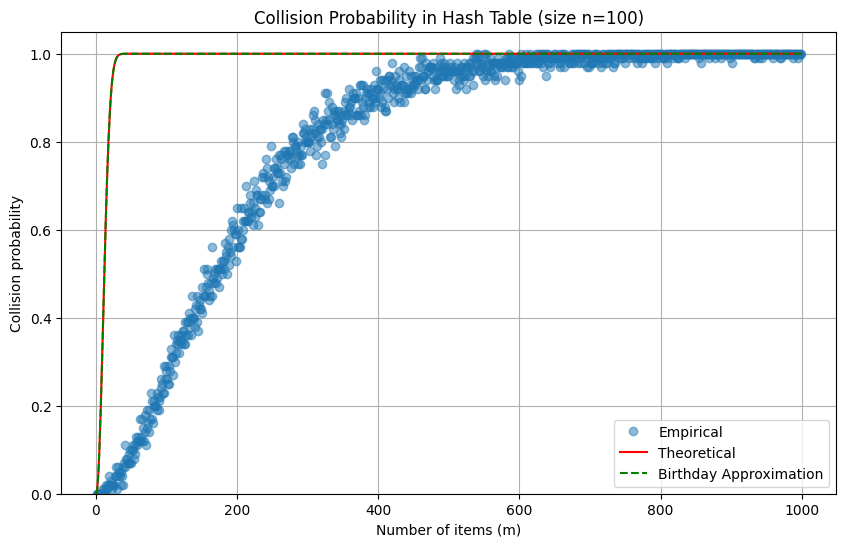

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, exp

def populate_hash_table(n, m):
    """
    Populate a hash table of size n with m items
    Returns an array of counts representing the hash table
    """
    table = np.zeros(n, dtype=int)
    for _ in range(m):
        idx = np.random.randint(0, n)
        table[idx] += 1
    return table

def collision_chance(n, m):
    """
    Empirical collision chance after m items inserted into hash table of size n
    """
    table = populate_hash_table(n, m)
    return np.sum(table > 1) / n  # sum the number of slots with collisions and divide by n

def collision_chance_theoretical(n, m):
    """
    Theoretical collision chance after m items inserted into hash table of size n
    Calculated using a logarithmic approach to avoid factorial overflow
    """
    if m > n:
        # When m > n, collision is guaranteed by pigeonhole principle
        return 1.0
    
    # Calculate log of the expression to avoid overflow
    # log(1 - n!/(n^m * (n-m)!))
    
    # Calculate log(n!/(n-m)!)
    log_numerator = sum(log(i) for i in range(n-m+1, n+1))
    
    # Calculate log(n^m)
    log_denominator = m * log(n)
    
    # Calculate log of the probability of NO collision
    log_no_collision = log_numerator - log_denominator
    
    # Convert back to probability of NO collision
    prob_no_collision = exp(log_no_collision)
    
    # Return probability of collision
    return 1 - prob_no_collision

# Alternative implementation using the birthday problem formula
def collision_chance_birthday(n, m):
    """
    Theoretical collision chance using the birthday problem approximation
    """
    if m > n:
        return 1.0
    
    # Probability of no collision
    p_no_collision = 1.0
    for i in range(m):
        p_no_collision *= (n - i) / n
        
    return 1 - p_no_collision

# Setup for plotting
n = 100
ms = range(1, 1000)  # Range of m values to plot

# Calculate empirical and theoretical probabilities
empirical_probs = [collision_chance(n, m) for m in ms]
theoretical_probs = [collision_chance_theoretical(n, m) for m in ms]
birthday_probs = [collision_chance_birthday(n, m) for m in ms]

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(ms, empirical_probs, 'o', alpha=0.5, label='Empirical')
plt.plot(ms, theoretical_probs, 'r-', label='Theoretical')
plt.plot(ms, birthday_probs, 'g--', label='Birthday Approximation')
plt.xlabel('Number of items (m)')
plt.ylabel('Collision probability')
plt.title(f'Collision Probability in Hash Table (size n={n})')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

### C: No vacancy
If we resign ourselves to the fact that we are likely to see collisions, we may at least find solace in the notion that we do not have wasted space (i.e. empty lists) in our hash table.  To this end, **derive a theoretical response to the following question: On average, how many items must we add to the hash table before every entry has at least one item in it.** Obviously, this is bounded below by $n$, but because there are undoubtedly collisions that occur before we put something in every space, then it is probably more than that.  You should recognize that this is a problem that we have already solved (in the context of testing the quality of random number generators), but cast in different terms - but the solutions are the same.  **Verify your theoretical response with empirical evidence (you will probably have to modify your hash simulator to answer this question).**  

### D: Distribution over items
Again, while it is obvious what the expected number of items per array index is, it not so obvious what the distribution over the number of items is.  This is important because this distribution is what characterizes worst case runtime.  **Derive the distribution 
$$ P(X_j = k),$$
where $X_j$ is the number of items in position $j$ (note that this is identical for all $j$, and $k\in\{0,1,2,\ldots\}$**.  This will of course be a function of both $m$ and $n$.  I will provide a hint for how to think about this problem.  First, let's consider $k=1$.  In what ways can $m$ balls be thrown such that exactly one of them lands in the $j$-th bin?  I argue that this occurs when the first ball thrown lands in the $j$-th bin, but none of the others do *or* when the second ball thrown lands in the $j$-th bin, but none of the others do, etc.  Considering $k=2$, what can happen such that exactly 2 balls land in bin $j$?  The first and second ball and no others, or the first and third ball and no others, or the second and third ball and no others, etc.  How can you write this notion compactly?  

As before, **provide empirical evidence supporting your derived quantity based on simulations of randomly generated hash tables.**   

### E: The worst worst case
While the previous section provides a distribution over individual array elements (and hence also the potential for extreme values), we might be interested in a holistic perspective over the entire table.  In particular, we might ask: how likely is it that the hash table index with the greatest number of entries exceeds some threshold after hashing $n$ elements.  While we won't derive this one ourselves (see P and C Lemma 5.1 for the proof sketch), what we can say is that
$$
P\left(\max_j(X_j)\ge \frac{3 \log n}{\log \log n}\right) \le \frac{1}{n}.
$$
**Perform a numerical experiment to show that this is true. (Although I admit that its not a very exciting result).**

## Part 2 - Hash Functions
In the previous section, we have shown analytically and empirically a number of interesting properties of hash tables, under the assumption that keys are uniformly distributed over indices.  However, it is easy for this assumption to fail - which is to say that it's easy to come up with bad hash functions.  Indeed, just like a random number generator that outputs a short repeating sequence is considered bad, a hash function that only maps to certain indices, or maps to some indices with greater frequency than others, will not achieve the performance standards (and statistical guarantees) that we described previously.  In this section, we will explore two hash functions.  Before we do so, it will be useful to have a corpus of real data on which to test.  To this end, I have included a corpus of words from wiktionary.  It also includes their frequency, which you could use as a value or something, but we will only be interested in the keys here.  To load this dataset, run the following box.



In [ ]:
import string

def remove_punctuation(text):
  """Removes punctuation from a string."""
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)
    
def contains_number_any(text):
    return any(character.isdigit() for character in text)

f = np.loadtxt('wiktionary.txt',delimiter = '\t',skiprows=1,dtype=str,converters={0:lambda x: x.strip()})
keys = []

for entry in f:
    k = remove_punctuation(entry[1]).lower()
    if contains_number_any(k):
        pass
    else:
        keys.append(k.lower())
print(keys)

### A: Homegrown
As a first crack, create your own hash function.  This function should accept a string of arbitrary length and should map it to an integer between $0$ and $m-1$ (or to some arbitrary range of integers which are then mapped to the desired range via modulus).  The one requirement for this assignment: don't try too hard.  Just come up with something that seems reasonable and we'll see how it turns out.  A function that might help is ord(s) which maps from a character to a unicode integer.  Once you have your hash function, use it to hash our dataset of keys into a hash table of roughly size $n=m/8$ (again simulating values by just keeping track of how many things have been hashed to that location).  Address the following questions: 
1. Does this hash function hash uniformly?
2. Is the distribution of key load consistent with Part 1D?

### B: Rolling Hash (not like that)
A very popular choice for hashing strings is the so-called polynomial rolling hash function.  It is quite simple:
$$
h(s) = \sum_{k=0}^{l-1} s[k] a^k \mod c,
$$
where $s$ is a string of length $l$, $h(s)$ its hash, and $a$ and $c$ parameters.  Note that this might look quite similar to LCG PRNGs, and indeed they are!  Some considerations are similar, most importantly the fact that $a$ and $c$ have to be chosen reasonably carefully in order to get good performance.  $a$ ought to be odd, so as to produce both odd and even numbers.  $c$ should be at least be co-prime with $a$, and might as well just be prime.  It should also be large.  Emperically good values are $a=31$ and $c=10^9 + 7$.

**Perform the same analysis as above, but using this hash function instead.**


## Part 3 - Bloom Filters
A hash table isn't any one particular thing so much as it is an idea.  As such, there are many variants on the idea of hashing a key to a location in an array that can be used for different things.  One such idea is the so-called [Bloom filter](https://en.wikipedia.org/wiki/Bloom_filter), which can be used to determine whether a (hashable) object is part of an existing set of things.  For example, imagine you're a record collector with a very large collection of records.  When you go to the record shop you'd like to quickly ascertain whether a record that you are considering buying is already in your collection.  A bloom filter will quickly give you an answer to that question, albeit with some chance of failure.  In particular, a Bloom filter will never produce false negatives - it will never tell you that the record isn't in your collection when it actually is - but it may produce false positives - it might tell you that you already have the record even when you don't.  However, the probability of this latter case can be bounded.

How does a Bloom filter work?  It is quite simple.  Our hash table is a boolean array of size $n$, initially set to all 0s.  As such, it is quite space efficient, with only 1 bit per array entry.  Along with this, we will maintain $k$ different hash functions, each of which presumably hashes uniformly.  To populate the hash table with a database (say of words or record titles), we add entries sequentially.  For each key, we apply each of our $k$ hash functions and set the bit at the corresponding index to true.  As such, after the first key is put in the table, exactly $k$ entries will have their bit flipped to 1.  For the second entry, we do the same - however we might end up with fewer than $2k$ bits set to 1 because for some of the hash functions, we could see a collision.  When this occurs, we just leave the bit set to one.  Repeat this process for all keys in the database.  

**Construct a Bloom filter of arbitrary size $n$ and number of hash functions $k$ using our database of words from previous sections.**

In [ ]:
# You may find the following code helpful for generating random hash functions.
import random

def is_prime(n):
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

def get_random_prime(start, end):
  while True:
    num = random.randint(start, end)
    if is_prime(num):
      return num

To query the Bloom filter, we simply apply our collection of hash functions to the query.  The query item is definitely not in the database if *any* of the hashed positions have a zero bit.  If all positions are one bits, then query may be in the database.  It's reasonable to ask: **what's the probability of a false positive?  Answer this question empirically by generating a large number of random strings (of length between - say - 4 and 8) and testing whether each produces a false positive or not.**  (You may ask yourself: what if I randomly draw a word that is actually in the database for this test?  Provide a brief argument for why this isn't a huge issue.)  

In [ ]:
import random
import string

# Again, this might be helpful
def generate_random_string(length):
  """Generates a random string of specified length.

  Args:
    length: The length of the random string.

  Returns:
    A random string.
  """
  characters = string.ascii_letters
  return ''.join(random.choice(characters) for _ in range(length))

It is in fact quite straightforward to analyze the expected false positive rate.  First, consider any word that we might add to the database.  If we apply a hash function to this word, under the uniform hashing assumption, we expect that this bit will remain zero with probability 
$$
P(A_i=0|k=1,m=1) = 1 - \frac{1}{n}.
$$
If we then ask how likely is it that the bit remains zero after apply $k$ uniform hashes to a single key, we have that
$$
P(A_i=0|m=1) = \left(1 - \frac{1}{n}\right)^k.
$$
Now, if apply the same logic, then after inserting $m$ keys, we will have 
$$
P(A_i=0) = \left(1 - \frac{1}{n}\right)^{mk}.
$$
Obviously, it will then be the case that the probability of a particular bit being true is
$$
P(A_i=1) = 1 - \left(1 - \frac{1}{n}\right)^{mk}
$$
**Continue this line of reasoning to derive the probability that after hashing a random key all of the locations hashed to contain 1s.  Comment on whether this agrees with your numberical experiments.  Given fixed $n$, determine minimal values of $m$ and $k$ such that the false positive rate will (on average) be less than 1%**. 
